<a href="https://colab.research.google.com/github/AbbySnt/EstadisticaAplicada_1990002/blob/main/sesion17_g44_26oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#librerias basicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive

In [7]:
#librerias especializadas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

#pmdarima
import pmdarima as pm

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
desempleo_mex = pd.read_excel('/desempleo_mex.xlsx')

In [12]:
desempleo_mex.head()

,meses,tasa de desempleo
0,2005/01,3.951998
1,2005/02,3.773302
2,2005/03,3.627075
3,2005/04,3.363412
4,2005/05,3.303693


In [13]:
desempleo_mex.dtypes

meses                 object
tasa de desempleo    float64
dtype: object

In [14]:
#Verificar los missing values
desempleo_mex.isnull().sum()

meses                0
tasa de desempleo    0
dtype: int64

In [18]:
#formato fecha
desempleo_mex['meses']=pd.to_datetime(desempleo_mex['meses'],format= '%Y/%m')
#index
desempleo_mex = desempleo_mex.set_index('meses')
#frecuencia
desempleo_mex =desempleo_mex.asfreq('MS')

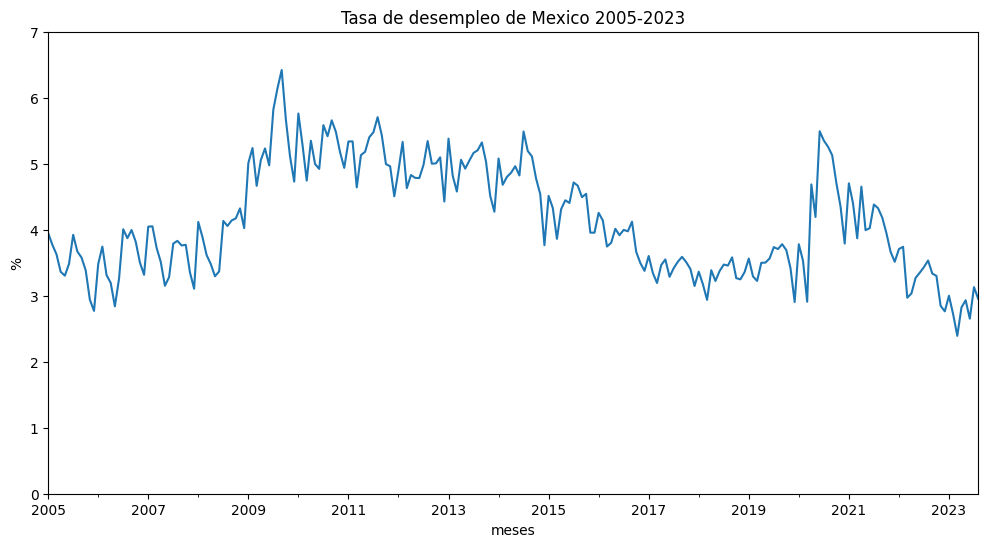

In [20]:
desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.title('Tasa de desempleo de Mexico 2005-2023')
plt.ylabel('%')
plt.ylim(0,7);

In [21]:
#prueba de raiz unitaria
prueba_adf = adfuller(desempleo_mex['tasa de desempleo'])
pvalue = prueba_adf[1]
pvalue.round(2)


0.25

No rechazamos Ho, lo que significa que la tasa de desempleo es una serie no estacionaria.

In [22]:
## 1eras diferencias
desempleo_mex['desempleo_diff'] = desempleo_mex['tasa de desempleo'].diff()

<Axes: xlabel='meses'>

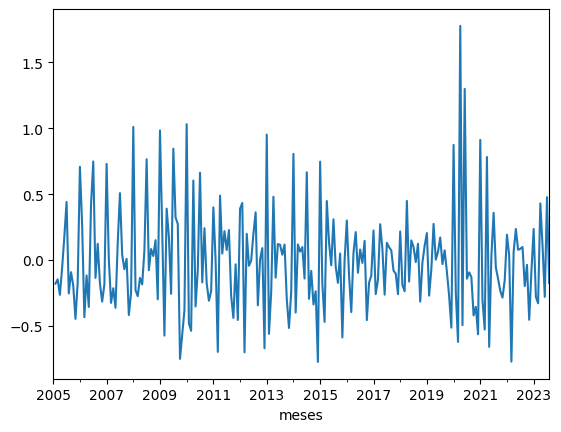

In [23]:
desempleo_mex['desempleo_diff'].plot()


In [24]:
#prueba de raiz unitaria
prueba_adf1 = adfuller(desempleo_mex['desempleo_diff'].dropna())
pvalue1 = prueba_adf1[1]
pvalue1.round(2)

0.01

Rechazamos Ho, significa que las primeras diferencias del desempleo es un proceso estacionario

* Desempleo I(1)
* 1eras diferencias del desempleo intergrado I(0)

### Identificar el orden del proceso

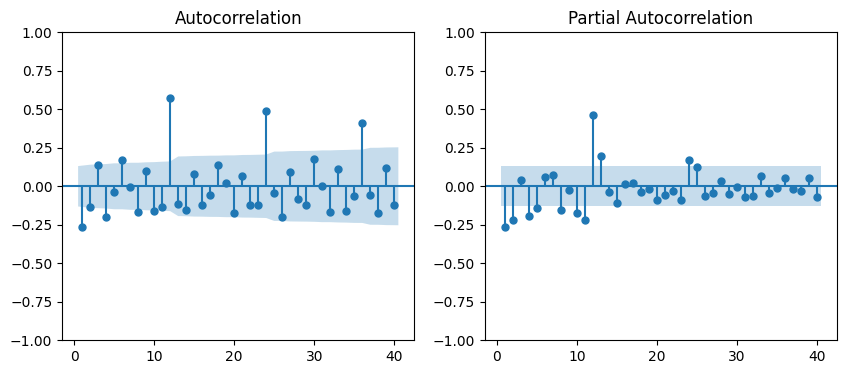

In [25]:
#Graficas de correlacion
ig,ax = plt.subplots(1,2,figsize=(10,4))
##1er subgrafica
plot_acf(desempleo_mex['desempleo_diff'].dropna(),zero=False, lags =40, ax=ax[0])
##2da subgrafica
plot_pacf(desempleo_mex['desempleo_diff'].dropna(),zero=False, lags=40, ax=ax[1])
plt.show()

Las graficas de correlacion muestran un patron regular, por lo tanto significa que estamos ante una serie con componente estacional.
Es decir, existen meses del año que la tasa de desempleo siempre sube y otros meses que la tasa de desempleo siempre baja.

In [26]:
##identificar el orden del ARIMA
pm.auto_arima(desempleo_mex['tasa de desempleo'],
              start_p=1, start_q=1,
              max_p=10,max_q=10,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=10,max_Q=10)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

La tasa de desempleo SARIMA(1,1,1)(1,0,1,12)

In [28]:
#Estimacion del modelo
model = ARIMA(desempleo_mex['tasa de desempleo'],
              order=(1,1,0),
              seasonal_order=(1,0,1,12))

results = model.fit()

In [31]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  tasa de desempleo   No. Observations:                  224
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.306
Date:                            Thu, 26 Oct 2023   AIC                             64.613
Time:                                    17:13:25   BIC                             78.241
Sample:                                01-01-2005   HQIC                            70.115
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.061     -6.075      0.000      -0.488      -0.250
ar.S.L12       0.9763      0.014   

In [32]:
#pronosticando el pasado
desempleo_mex['desempleo_arima'] = results.predict()

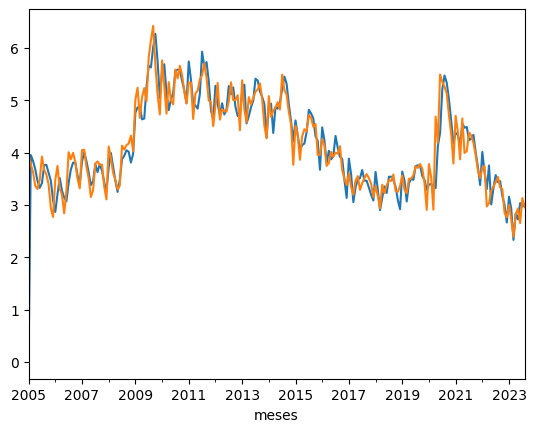

In [34]:
desempleo_mex['desempleo_arima'].plot()
desempleo_mex['tasa de desempleo'].plot();

In [36]:
desempleo_mex.tail()

,tasa de desempleo,desempleo_diff,desempleo_arima
meses,,,
2023-04-01,2.822799,0.430258,2.837607
2023-05-01,2.931125,0.108327,2.722100
2023-06-01,2.652033,-0.279093,3.034389
2023-07-01,3.129870,0.477837,2.968335
2023-08-01,2.955346,-0.174524,3.007015


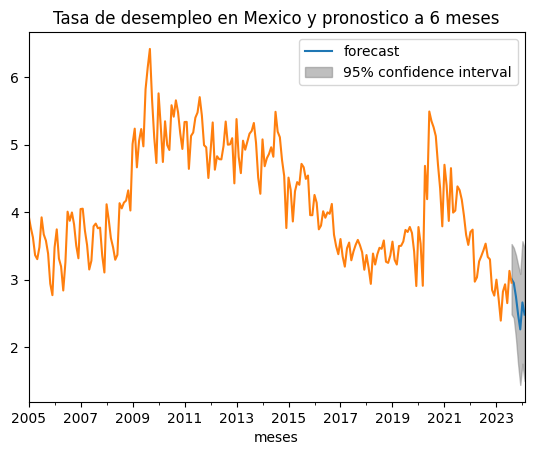

In [39]:
plot_predict(results,'2023-08-01','2024-02-01')
desempleo_mex['tasa de desempleo'].plot()
plt.title('Tasa de desempleo en Mexico y pronostico a 6 meses')
plt.show()

In [40]:
forecast = results.get_forecast(steps = 6)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


In [42]:
inicio ='2023-09-01'
fin = '2024-02-01'

In [43]:
pronostico_valor = forecast_mean[inicio:fin]
pronostico_intervalos =forecast_ci.loc[inicio:fin]


In [44]:
pronostico_valor

2023-09-01    2.951736
2023-10-01    2.750668
2023-11-01    2.483561
2023-12-01    2.262439
2024-01-01    2.661990
2024-02-01    2.481789
Freq: MS, Name: predicted_mean, dtype: float64

In [45]:
pronostico_intervalos #da el intervalo de confianza al 95%

,lower tasa de desempleo,upper tasa de desempleo
2023-09-01,2.431391,3.472082
2023-10-01,2.135374,3.365962
2023-11-01,1.750114,3.217008
2023-12-01,1.439564,3.085313
2024-01-01,1.754473,3.569507
2024-02-01,1.498254,3.465324


In [48]:
#juntarlos en un data frame
df_forecast = pd.DataFrame({
'pronostico': pronostico_valor,
'limite inferior':pronostico_intervalos.iloc[:,0],
'limite superior':pronostico_intervalos.iloc[:,1]
})

In [49]:
df_forecast

,pronostico,limite inferior,limite superior
2023-09-01,2.951736,2.431391,3.472082
2023-10-01,2.750668,2.135374,3.365962
2023-11-01,2.483561,1.750114,3.217008
2023-12-01,2.262439,1.439564,3.085313
2024-01-01,2.661990,1.754473,3.569507
2024-02-01,2.481789,1.498254,3.465324


In [52]:
print(f'La tasa de desempleo pronosticada para septiembre del 2023 es de {df_forecast.iloc[0,0].round(1)}% \nCon un 95% de confianza la tasa de desempleo esta entre {df_forecast.iloc[0,1].round(1)}% y {df_forecast.iloc[0,2].round(1)}%')

La tasa de desempleo pronosticada para septiembre del 2023 es de 3.0% 
Con un 95% de confianza la tasa de desempleo esta entre 2.4% y 3.5%


## Pronostico IPC BMV

In [95]:
ipc_bmv = pd.read_excel('/ipc_bmv (2).xlsx')

In [96]:
ipc_bmv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-22,47485.738281,47672.921875,45677.269531,45803.328125,45803.328125,834808300
1,2018-10-29,45763.089844,45823.449219,43407.488281,45446.828125,45446.828125,1151016200
2,2018-11-05,45449.050781,46975.179688,42816.750000,44263.738281,44263.738281,1230024600
3,2018-11-12,44098.929688,44253.109375,41284.039063,42319.269531,42319.269531,1012842300
4,2018-11-19,41885.621094,42505.140625,41055.808594,41144.328125,41144.328125,558246700


In [97]:
ipc_bmv.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [104]:
ipc_bmv.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [99]:
ipc_bmv = ipc_bmv.set_index('Date')
#frecuencia
ipc_bmv =ipc_bmv.asfreq('W-MON')

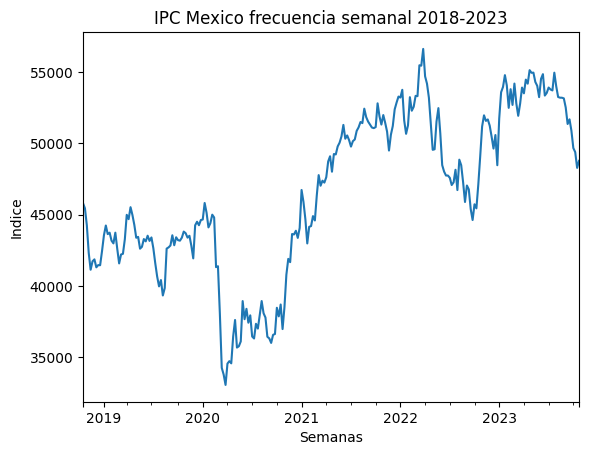

In [103]:
ipc_bmv['Adj Close'].plot()
plt.title('IPC Mexico frecuencia semanal 2018-2023')
plt.ylabel('Indice')
plt.xlabel('Semanas');

In [105]:
#prueba de la raiz unitaria
prueba_adf = adfuller(ipc_bmv['Adj Close'])
pvalue =  prueba_adf[1]
pvalue.round(2)

0.54

No rechazamos Ho, El IPC es una serie no estacionaria

In [106]:
#Aplicar primeras diferencias
ipc_bmv['ipc_diff'] = ipc_bmv['Adj Close'].diff()

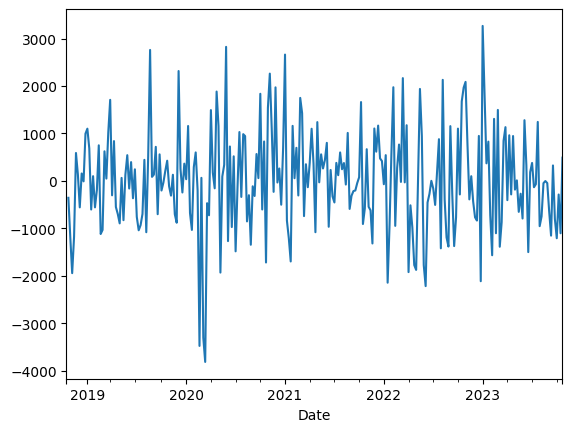

In [108]:
#graficar
ipc_bmv['ipc_diff'].plot();

In [109]:
#prueba de raiz unitaria a las 1eras diferencias
prueba_adf1 = adfuller(ipc_bmv['ipc_diff'].dropna())
pvalue1 =  prueba_adf1[1]
pvalue1.round(2)

0.0

Rechazamos Ho, las primeras diferencias del IPC son una serie estacionaria

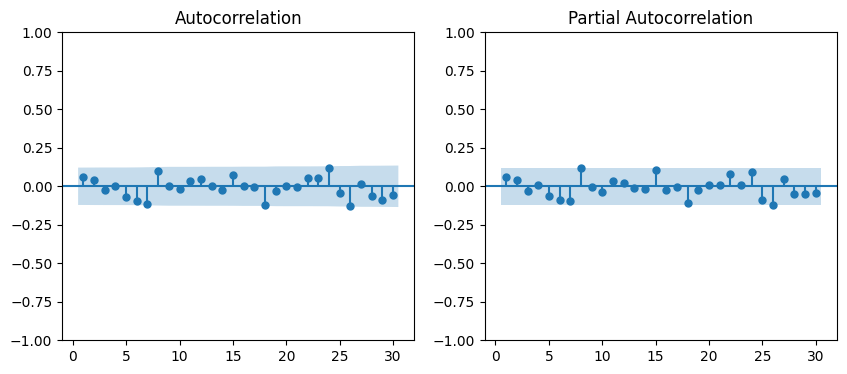

In [111]:
#grafica correlaciones
ig,ax = plt.subplots(1,2,figsize=(10,4))
##1er subgrafica
plot_acf(ipc_bmv['ipc_diff'].dropna(),zero=False, lags =30, ax=ax[0])
##2da subgrafica
plot_pacf(ipc_bmv['ipc_diff'].dropna(),zero=False, lags=30, ax=ax[1])
plt.show()

Es una serie que no tiene un componente estacional, porque no hay un patron repetitivo en las correlaciones (las que nos interesa son las lineas que se salen de los intervalos entonces tecnicamente en este caso todas las lineas son 0)

In [113]:
##identificar el orden del ARIMA
pm.auto_arima(ipc_bmv['Adj Close'],
              start_p=1, start_q=1,
              max_p=7,max_q=7,
              ic='aic',
              seasonal=False)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

ARIMA(0,1,0), las primeras diferencias son un ARIMA(0,0,0) o lo que es lo mismo es un ruido blanco y por lo tanto no se podria pronosticar